In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import numpy as np
from scipy.signal import windows

import utils

# Applying a Hann-Window to ALOS-PALSAR L1.1 Data

The purpose of this notebook is to visualize a single-look complex (SLC) SAR dataset collected by ALOS PALSAR. In addition, the dataset will be filtered in the frequency domain using a Hann-window.

The PALSAR product used for this analysis is *ALPSRP139670660*. It can be downloaded using the [ASF Vertex](https://search.asf.alaska.edu/#/) tool.

## 1. Read the complex SLC data

First, the dataset has to be read into a Numpy-array. To do that, I use a code snipped provided to me by Synspective (imported here from `utils.py` as `read_alospalsar_image`). The path specified in `product_path` has to be changed according to where the product is.

In [2]:
product_path = Path(
    "/home/debian/data_share/alos_palsar/ALPSRP139670660-H1.1__A"
)  # noqa
fname = "IMG-HH-ALPSRP139670660-H1.1__A"

slc = utils.read_alospalsar_image(product_path / fname)
n_lines = slc.shape[0]
n_pixels = slc.shape[1]

# 2. Create an overview image

After reading the dataset, we visualize it using its power/ intensity on a logarithmic scale.

In [3]:
slc_intensity_dB = 20 * np.log10(np.abs(slc))

Visualize intensity image.

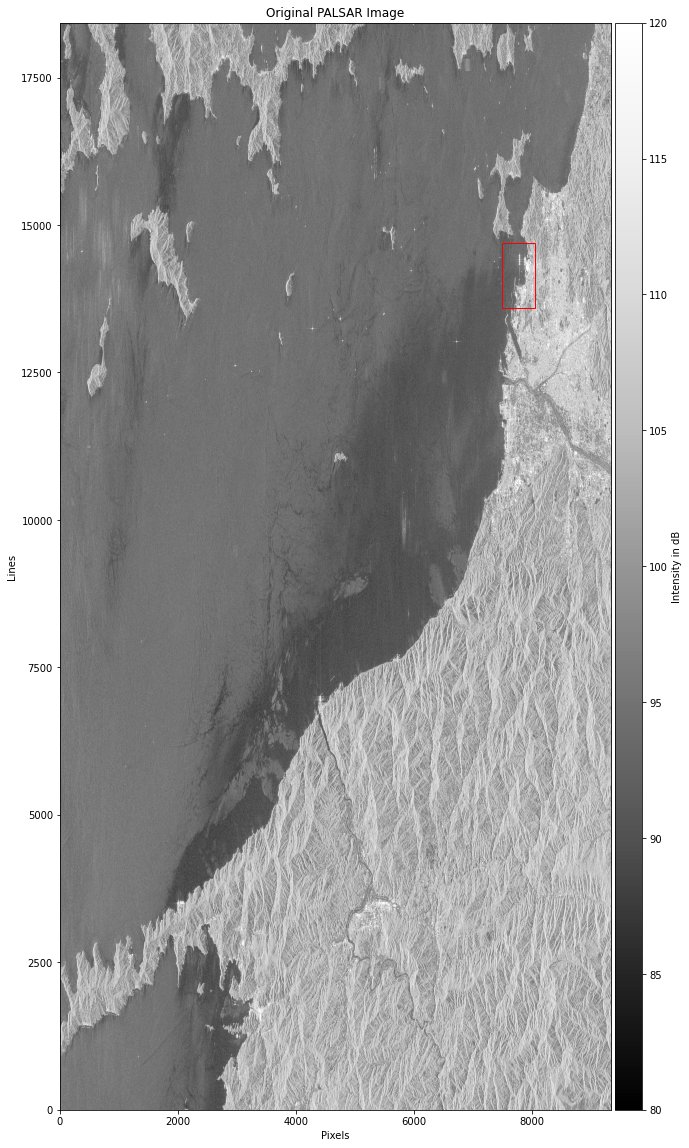

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(30,20))

img = ax.imshow(
    slc_intensity_dB,
    origin="lower",
    vmin=80,
    vmax=120,
    cmap="Greys_r",
    aspect="equal",
    extent=(0,n_pixels,0,n_lines),
)

line_min = 13600
line_max = 14700
pixel_min = 7500
pixel_max = 8050
rect = patches.Rectangle((pixel_min, line_min), 
                         pixel_max-pixel_min,
                         line_max-line_min,
                         linewidth=1, 
                         edgecolor='r', 
                         facecolor='none',
                        )
ax.add_patch(rect)

ax.set_ylabel("Lines")
ax.set_xlabel("Pixels")
ax.set_title("Original PALSAR Image")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(img, cax=cax, label="Intensity in dB")

if 1:
    savedir = Path("../results") 
    Path(savedir).mkdir(exist_ok=True)
  
    file_name = "palsar_image_original.png"
    savepath = savedir / file_name
    plt.savefig(savepath, bbox_inches="tight")

The scene is quite large, and this visualization does not allow to see many details. Therefore, let's look at a subset of the data set. Specifically, we will look at the area around the Matsuyama Seaport and Aiport (highlighted in red in the figure above).

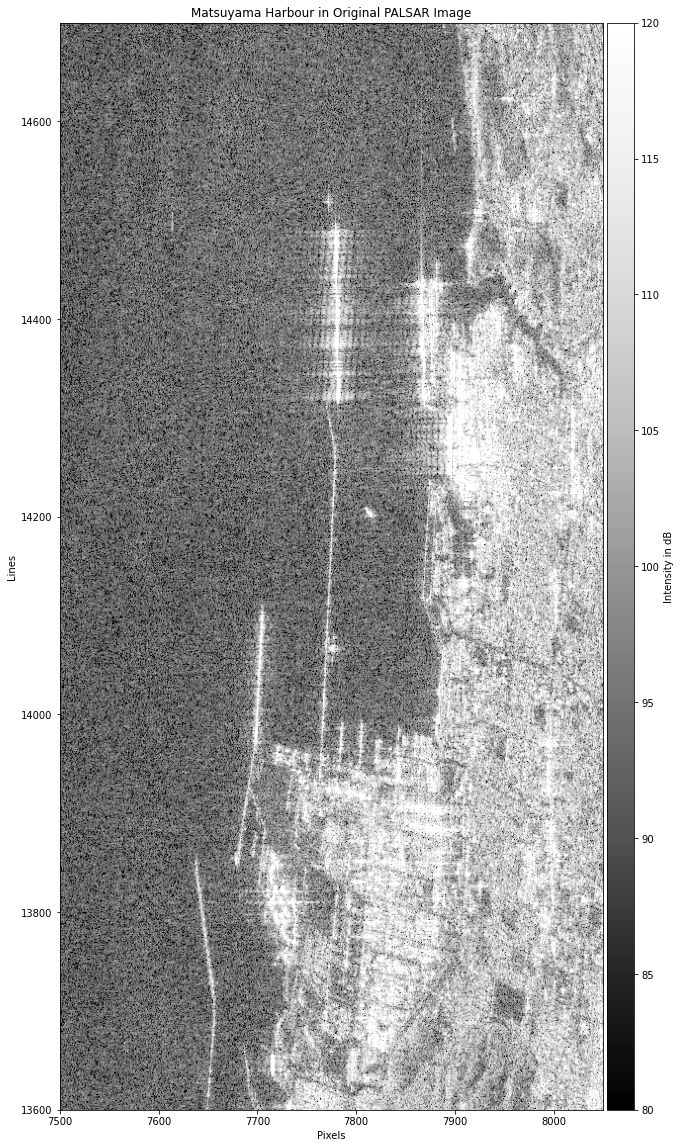

In [5]:
extent = (pixel_min, pixel_max, line_min, line_max)

fig, ax = plt.subplots(1, 1, figsize=(30,20))

img = ax.imshow(
    slc_intensity_dB[line_min:line_max, pixel_min:pixel_max],
    origin="lower",
    vmin=80,
    vmax=120,
    cmap="Greys_r",
    aspect="equal",
    extent=extent,
)

ax.set_ylabel("Lines")
ax.set_xlabel("Pixels")
ax.set_title("Matsuyama Harbour in Original PALSAR Image")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(img, cax=cax, label="Intensity in dB")

In this image, it can be seen that the sidelobes caused by the Point Spread Function (PSF) in range are quite strong. This effect is particularly strong in the densely urbanized area around the harbour due to the high concentration of strong, point-like scatterers in that region.

To attenuate or even remove the sidelobes, we need to apply a filter in the frequency domain.

# 3. Implement frequency based windowing

## 3.1 For each line, compute the Fourier transform with a size of 16384

Numpy's fft function offers the possibility to compute the FFT for all lines at once (`axis=1`). We use $n_\text{FFT}=16384$ samples for the FFT---a power of 2---to make full use of the Radix2 algorithm.

In [6]:
n_fft = 16384
slc_fft = np.fft.fftshift(np.fft.fft(slc, n=n_fft, axis=1), axes=1)

Visualize spectrum of single line

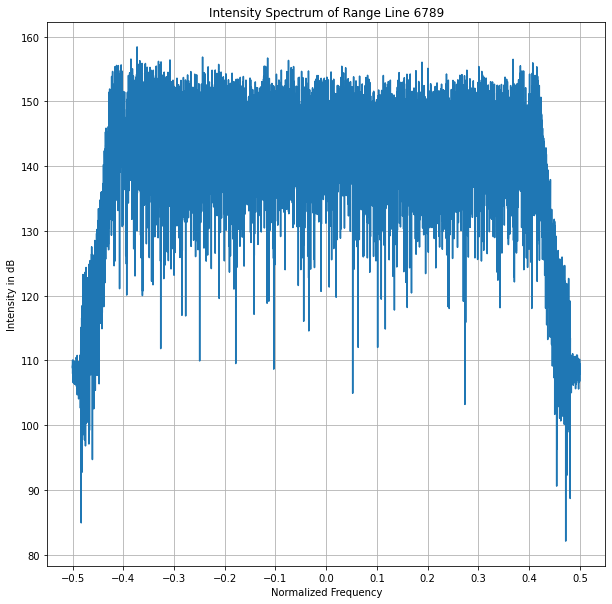

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

index_sample_line = 6789

freq = np.linspace(-0.5, 0.5, n_fft)
ax.plot(freq, 20*np.log10(np.abs(slc_fft[index_sample_line, :])))
ax.grid(True)

ax.set_xlabel("Normalized Frequency")
ax.set_ylabel("Intensity in dB")
ax.set_title(f"Intensity Spectrum of Range Line {index_sample_line}")

plt.xticks(np.arange(-0.5, 0.6, 0.1));

if 1:
    savedir = Path("../results") 
    Path(savedir).mkdir(exist_ok=True)
  
    file_name = f"range_spectrum_line_{index_sample_line}_no_filter.png"
    savepath = savedir / file_name
    plt.savefig(savepath, bbox_inches="tight")

It can be seen in this figure that spectrum of the sample line takes up almost the complete sampling bandwidth. This wide bandwidth allow for a high a resolution in the spatial domain (i.e., a narrow peak of the PSF), but also high sidelobes. Hence, reducing the bandwidth and will cause a lower resolution in the spatial domain and lower sidelobes. We are more than willing to tolerate the loss in the resolution, because in the original product the sidelobes are so high that making use of the high range resolution is not possible, anyway. 

## 3.2 Apply the Hanning window to the central part of the frequency spectrum

The Hanning (or Hann) window is a popular choice for window functions. It is defined as

$$
w(n)_\text{Hann} = 0.5 - 0.5\cos\bigg(\frac{2\pi n}{M}\bigg)\quad\text{for}\quad 0 \leq n \leq M-1 \:,
$$

where $n$ is the sample index and $M$ is the number of samples in the signal (in our case, the number of samples used for the FFT).

Conveniently, the Hanning-window is implemented in `scipy`. We set its to cover the central portion of the range spectrum.

In [8]:
n_hann = int(n_fft / 2)

ind_hann_start = int(n_fft / 4)
ind_hann_end = ind_hann_start + n_hann

hann_window = np.zeros(n_fft)
hann_window[ind_hann_start:ind_hann_end] = windows.hann(n_hann)

Plot Hann-window

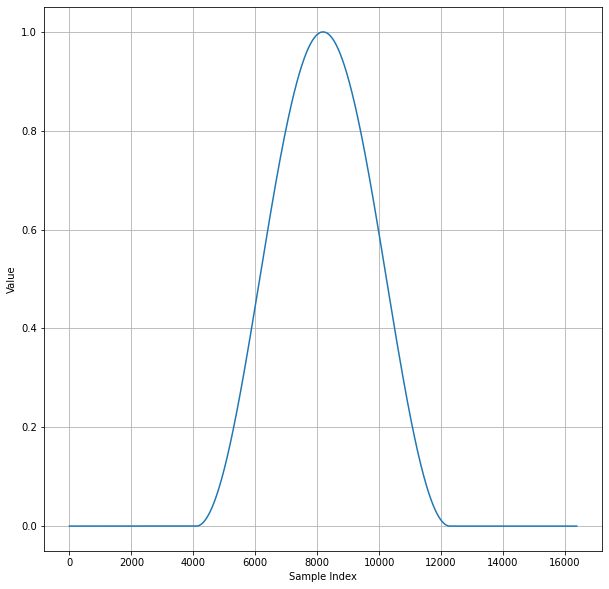

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(hann_window)
ax.grid(True)

ax.set_xlabel("Sample Index")
ax.set_ylabel("Value")

plt.xticks(np.arange(0, n_fft, 2000));

if 1:
    savedir = Path("../results") 
    Path(savedir).mkdir(exist_ok=True)
  
    file_name = "hanning_window.png"
    savepath = savedir / file_name
    plt.savefig(savepath, bbox_inches="tight")

Apply Hann-window to the range spectra. We use Numpy-broadcasting to apply the window to all range spectra at once.

In [10]:
slc_fft_filtered = slc_fft * hann_window[None, :]

Visualize spectra after application of Hann-window

Visualize single line of filtered spectrum

/tmp/ipykernel_14840/783098973.py:6: RuntimeWarning: divide by zero encountered in log10
  ax.plot(freq, 20*np.log10(np.abs(slc_fft_filtered[index_sample_line, :])))


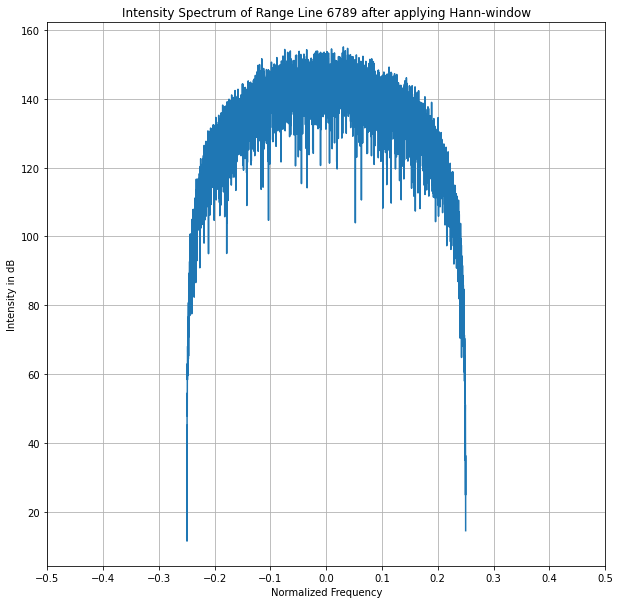

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

index_sample_line = 6789

freq = np.linspace(-0.5, 0.5, n_fft)
ax.plot(freq, 20*np.log10(np.abs(slc_fft_filtered[index_sample_line, :])))
ax.grid(True)

ax.set_xlabel("Normalized Frequency")
ax.set_ylabel("Intensity in dB")
ax.set_title(f"Intensity Spectrum of Range Line {index_sample_line} after applying Hann-window")

plt.xticks(np.arange(-0.5, 0.6, 0.1));

if 1:
    savedir = Path("../results") 
    Path(savedir).mkdir(exist_ok=True)
  
    file_name = f"range_spectrum_line_{index_sample_line}_filtered.png"
    savepath = savedir / file_name
    plt.savefig(savepath, bbox_inches="tight")

Now the spectrum is a lot more narrow, which should significantly decrease the sidelobe levels in the spatial domain.

## 3.3 Compute Inverse Fourier Transform

To verify that the sidelobes have indeed decreased, we transform the range spectra back to the original range lines in the spatial domain.

In [12]:
slc_filtered = np.fft.ifft(slc_fft_filtered)
slc_filtered = slc_filtered[:, :n_pixels] #Crop filtered image back to original dimensions

Visualize filtered image (Matsuyama Seaport is shown in red).

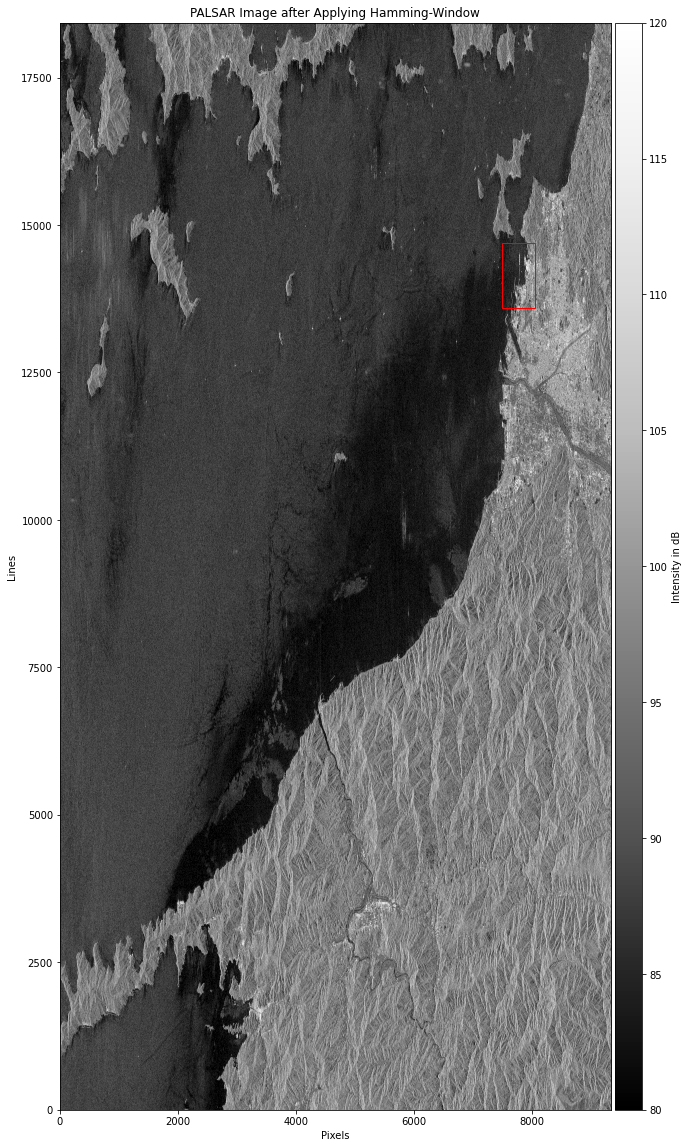

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(30, 20))

slc_filtered_dB = 20 * np.log10(np.abs(slc_filtered))

img = ax.imshow(
    slc_filtered_dB,
    origin="lower",
    vmin=80,
    vmax=120,
    cmap="Greys_r",
    aspect="equal",
    extent=(0,n_pixels,0,n_lines),
)

rect = patches.Rectangle((pixel_min, line_min), 
                         pixel_max-pixel_min,
                         line_max-line_min,
                         linewidth=1, 
                         edgecolor='r', 
                         facecolor='none',
                        )
ax.add_patch(rect)

ax.set_ylabel("Lines")
ax.set_xlabel("Pixels")
ax.set_title("PALSAR Image after Applying Hamming-Window")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(img, cax=cax, label="Intensity in dB")

if 1:
    savedir = Path("../results") 
    Path(savedir).mkdir(exist_ok=True)
  
    file_name = "palsar_image_filtered.png"
    savepath = savedir / file_name
    plt.savefig(savepath, bbox_inches="tight")

# 4. Compare Original and Filtered Image above Matsuyama Airport

Let's compare the region around Matsuyama Seaport before and after application of the Hanning-Window. 

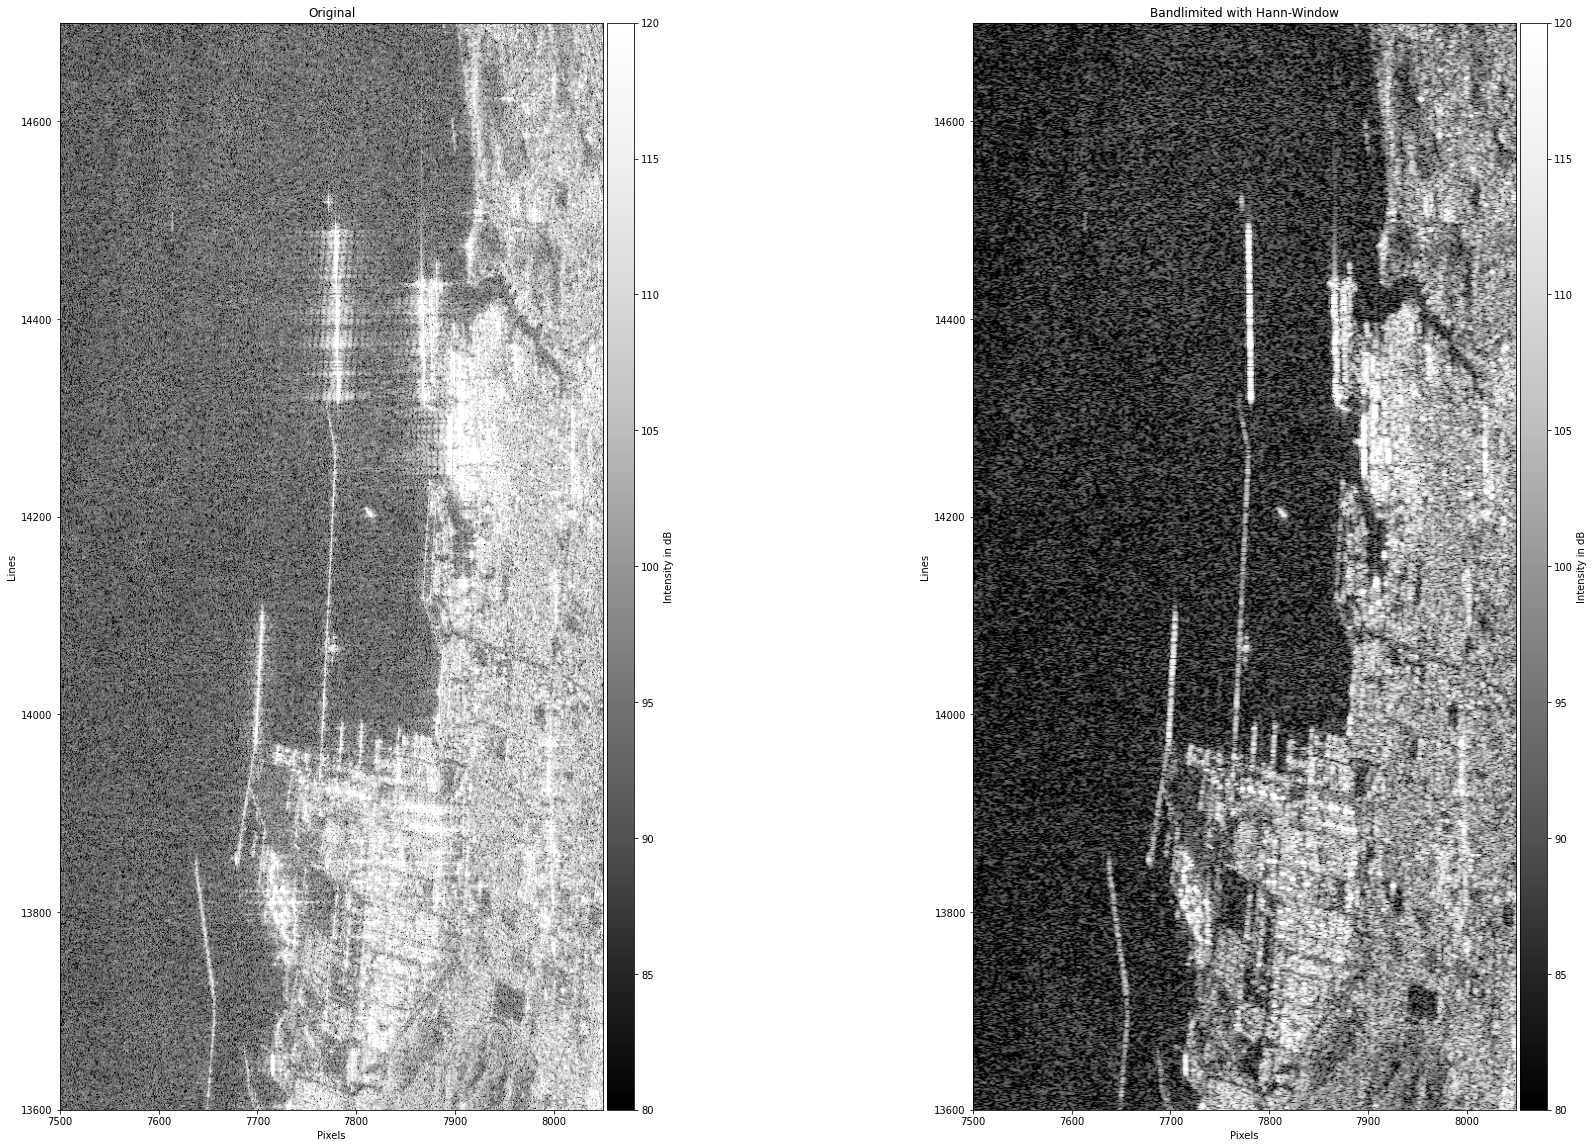

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(30, 20))

extent = (pixel_min, pixel_max, line_min, line_max)

ax = axes[0]
img = ax.imshow(
    slc_intensity_dB[line_min:line_max, pixel_min:pixel_max],
    origin="lower",
    vmin=80,
    vmax=120,
    cmap="Greys_r",
    aspect="equal",
    extent=extent,
)

ax.set_ylabel("Lines")
ax.set_xlabel("Pixels")
ax.set_title("Original")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(img, cax=cax, label="Intensity in dB")

ax = axes[1]
img = ax.imshow(
    slc_filtered_dB[line_min:line_max, pixel_min:pixel_max],
    origin="lower",
    vmin=80,
    vmax=120,
    cmap="Greys_r",
    aspect="equal",
    extent=extent,
)

ax.set_ylabel("Lines")
ax.set_xlabel("Pixels")
ax.set_title("Bandlimited with Hann-Window")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(img, cax=cax, label="Intensity in dB")

if 0:
    savedir = Path("../results") 
    Path(savedir).mkdir(exist_ok=True)
  
    file_name = "palsar_hanning_window_comparison.png"
    savepath = savedir / file_name
    plt.savefig(savepath, bbox_inches="tight")

It can be seen that both the noise level and the PSF sidelobe levels have decreased due to the bandwidth limitation caused by the Hanning-window. Thus, the product is now in much better shape for further processing.